# First method for outlier detection implemented with Pandas 

## Preliminary upload 

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import ast
import hdbscan
from sklearn.decomposition import PCA , KernelPCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans , DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

### Global function set up

In [26]:
def invert_dol(d):
    return dict((v, k) for k in d for v in d[k])

### Import Data 

In [27]:
dataset=pd.read_csv("Projet critéo/Dataset/DataSet initial/criteo_graph_enriched.csv", encoding = "ISO-8859-1", sep=";")
google_class= pd.read_csv("Projet critéo/Dataset/DataSet initial/google_product_taxonomy2.csv",";",encoding = "ISO-8859-1")
google_class=google_class.set_index('uc_id')

In [28]:
google_class

,uc_level_1,uc_level_2,uc_level_3,uc_level_4,uc_level_5,uc_level_6,uc_level_7,Concatenation,Concatenation_12
uc_id,,,,,,,,,
1,Animals & Pet Supplies,NaN,NaN,NaN,NaN,NaN,NaN,Animals & Pet Supplies------,Animals & Pet Supplies_
3237,Animals & Pet Supplies,Live Animals,NaN,NaN,NaN,NaN,NaN,Animals & Pet Supplies-Live Animals-----,Animals & Pet Supplies_Live Animals
2,Animals & Pet Supplies,Pet Supplies,NaN,NaN,NaN,NaN,NaN,Animals & Pet Supplies-Pet Supplies-----,Animals & Pet Supplies_Pet Supplies
3,Animals & Pet Supplies,Pet Supplies,Bird Supplies,NaN,NaN,NaN,NaN,Animals & Pet Supplies-Pet Supplies-Bird Suppl...,Animals & Pet Supplies_Pet Supplies
7385,Animals & Pet Supplies,Pet Supplies,Bird Supplies,Bird Cage Accessories,NaN,NaN,NaN,Animals & Pet Supplies-Pet Supplies-Bird Suppl...,Animals & Pet Supplies_Pet Supplies
499954,Animals & Pet Supplies,Pet Supplies,Bird Supplies,Bird Cage Accessories,Bird Cage Bird Baths,NaN,NaN,Animals & Pet Supplies-Pet Supplies-Bird Suppl...,Animals & Pet Supplies_Pet Supplies
7386,Animals & Pet Supplies,Pet Supplies,Bird Supplies,Bird Cage Accessories,Bird Cage Food & Water Dishes,NaN,NaN,Animals & Pet Supplies-Pet Supplies-Bird Suppl...,Animals & Pet Supplies_Pet Supplies
4989,Animals & Pet Supplies,Pet Supplies,Bird Supplies,Bird Cages & Stands,NaN,NaN,NaN,Animals & Pet Supplies-Pet Supplies-Bird Suppl...,Animals & Pet Supplies_Pet Supplies
4990,Animals & Pet Supplies,Pet Supplies,Bird Supplies,Bird Food,NaN,NaN,NaN,Animals & Pet Supplies-Pet Supplies-Bird Suppl...,Animals & Pet Supplies_Pet Supplies


## Data set pre-analysis 

### Statistics

In [7]:
n_xd_id = dataset.xd_id.nunique()
avg_produt_per_uid = dataset.groupby('user_id').nb_views.sum().mean()
avg_unique_produt_per_uid = dataset.groupby('user_id').product.count().mean() #245.21
print ("numbre of cross_device on the sample : ",n_xd_id)
print ("average product per user Id : ",avg_produt_per_uid)
print ("average unique product per user Id : ",avg_unique_produt_per_uid)

('numbre of cross_device on the sample : ', 1000)
('average product per user Id : ', 336.52288815479)
('average unique product per user Id : ', 245.21189240207644)


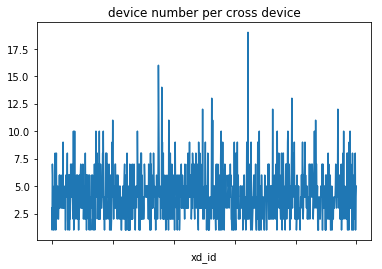

In [8]:
xd_id_group = dataset.groupby('xd_id')['user_id'].nunique()
distribution_u_id_selon_xd_id = xd_id_group.describe()
xd_id_group.plot(title="device number per cross device")

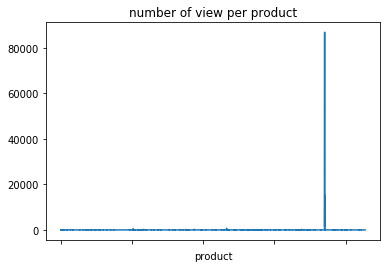

In [13]:
product_group_per_views = dataset.groupby('product').nb_views.sum()
product_group_per_views.plot(title="number of view per product")

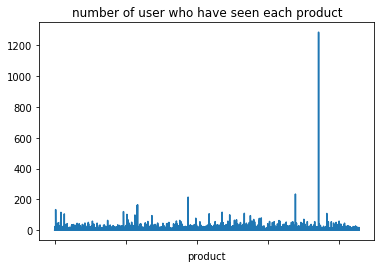

In [14]:
product_group_per_user_id = dataset.groupby('product').user_id.count()
product_group_per_user_id.plot(title="number of user who have seen each product")

### Gender error detection 

#### Extraction of product cell's content

In [9]:
def extract_product (dataset): 
    dataset_added=dataset
    df2 = pd.DataFrame(dataset_added['product'].str.split(',',-1,False).tolist())
    df2_0=pd.DataFrame(df2[0].str.split('"',-1,False).tolist())
    df2_3=pd.DataFrame(df2[3].str.split('"',-1,False).tolist())
    dataset_added['product_id'] = df2_0[1]
    dataset_added['product_gender']=df2[1]
    dataset_added['product_gender_proba'] = df2[2]
    dataset_added['product_Gid']=pd.to_numeric(df2_3[1],errors='coerce')
    return (dataset_added)
dset = extract_product (dataset)

#### Extract anormal gender

In [10]:
def set_uid_gender(dataset):
    dataset['ponderation'] = dataset['product_gender_proba'].multiply(dataset['nb_views'])
    #dataset['ponderation'] = dataset['product_gender_proba']
    dataset_genred = dataset.groupby('product_gender').ponderation.sum()
    dataset_genred = dataset_genred.map(lambda x: min(x / dataset.ponderation.sum(),1))
    return dataset_genred.to_dict()

def set_gender(dataset):
    uid_grouped = dataset.groupby('user_id')[['product_id', 'nb_views', 'product_gender', 'product_gender_proba']]
    user_id_mapped = {unique_user_id: '' for unique_user_id in dataset.user_id.unique()}
    for i, user_id in enumerate(user_id_mapped.keys()):
        working_uid = uid_grouped.get_group(user_id)
        user_id_mapped[user_id] = set_uid_gender(working_uid) 
    dataset['user_id_sex'] = dataset.user_id.map(user_id_mapped)
    return dataset
    print (user_id_mapped)

def set_gender_reference(dataset):
    xid_grouped = dataset.groupby('xd_id')
    xd_id_mapped = {unique_xd_id: '' for unique_xd_id in dataset.xd_id.unique()}
    for i, xdid in enumerate(xd_id_mapped):
        working_xid = xid_grouped.get_group(xdid).drop_duplicates(subset = 'user_id')
        xd_id_mapped[xdid] = genderize(working_xid)
    dataset['xd_id_sex_interval'] = dataset.xd_id.map(xd_id_mapped)
    return dataset
        
def genderize(working_xid):
    U, F, M = [], [], []
    for uid_gender in working_xid.user_id_sex:
        try:
            U.append(uid_gender['UNISEX'])
            F.append(uid_gender['FEMALE'])
            M.append(uid_gender['MALE'])
        except:
            pass
    return [validation_interval(F), validation_interval(M), validation_interval(U)]

def validation_interval(liste, seuil=2):
    try:
        answer = [max(0,statistics.mean(liste) - seuil * statistics.stdev(liste)), min(statistics.mean(liste) + seuil * statistics.stdev(liste),1)]
    except:
        answer = [0,1]
    return answer

def find_anomaly(working_uid):
    gender = working_uid.user_id_sex.values[0]
    for key, value in gender.items():
        if key == 'FEMALE':
            if value < working_uid.xd_id_sex_interval.values[0][0][0] or value > working_uid.xd_id_sex_interval.values[0][0][1]:
                return True
        elif key == 'MALE':
            if value < working_uid.xd_id_sex_interval.values[0][1][0] or value > working_uid.xd_id_sex_interval.values[0][1][1]:
                return True
        elif key == 'UNISEX':
            if value < working_uid.xd_id_sex_interval.values[0][2][0] or value > working_uid.xd_id_sex_interval.values[0][2][1]:
                return True
    return False
    
def set_anomaly(dataset):
    uid_grouped = dataset.groupby('user_id')
    user_id_mapped = {unique_user_id: '' for unique_user_id in dataset.user_id.unique()}
    progress = 0.1
    for i, user_id in enumerate(user_id_mapped.keys()):
        working_uid = uid_grouped.get_group(user_id).drop_duplicates(subset = 'user_id')
        anomaly = find_anomaly(working_uid)
        user_id_mapped[user_id] = anomaly
        dataset['anomaly'] = dataset.user_id.map(user_id_mapped)
    print('--> {} anomalies detected among xd_id ({}%)'.format(len(dataset[dataset.anomaly].xd_id.unique()), round((len(dataset[dataset.anomaly].xd_id.unique()) / len(dataset.xd_id.unique()))*100,2)))
    print('--> {} ud_id are missclassified ({}%)'.format(len(dataset[dataset.anomaly].user_id.unique()), round((len(dataset[dataset.anomaly].user_id.unique()) / len(dataset.user_id.unique()))*100,2)))
    return dataset

In [ ]:
dataset_gender_detection = set_gender(dset)
dataset_gender_detection = set_gender_reference(dataset_gender_detection)
dataset_gender_detection = set_anomaly(dataset_gender_detection)
print "here is the abnormal user id : ",dataset_gender_detection[dataset.anomaly].xd_id.unique()